# 1. Obtenció i tractament de dades

### 1.1 Ús de la llibreria LabelMe

In [2]:
!labelme 

failed to create process.


###  1.2 Creació de la base de dades

In [1]:
#importació de llibreries necessàries
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import shutil
import math

In [2]:
#limitació de la memòria GPU 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
imatges = tf.data.Dataset.list_files('dades2\\imatges\\*.jpg') # introduïm les imatges

In [4]:
def carregar_imatge(imatge): #funció per a carregar imatges
    byte_img = tf.io.read_file(imatge)
    img = tf.image.decode_jpeg(byte_img)
    return img

In [5]:
imatges = imatges.map(carregar_imatge) #executem la funció 

In [6]:
imatges.as_numpy_iterator().next() 

array([[[ 84,  80,  79],
        [ 85,  81,  80],
        [ 77,  73,  72],
        ...,
        [ 58,  50,  48],
        [ 60,  52,  50],
        [ 49,  41,  39]],

       [[ 66,  62,  61],
        [ 78,  74,  73],
        [ 81,  77,  76],
        ...,
        [ 71,  67,  64],
        [ 65,  60,  57],
        [ 48,  44,  41]],

       [[ 54,  50,  47],
        [ 74,  70,  67],
        [ 86,  82,  79],
        ...,
        [ 73,  75,  70],
        [ 59,  60,  55],
        [ 40,  42,  37]],

       ...,

       [[ 57,  65,  68],
        [ 87,  95,  97],
        [126, 131, 134],
        ...,
        [110, 116, 106],
        [101, 107,  97],
        [ 68,  74,  64]],

       [[ 55,  63,  65],
        [ 65,  74,  73],
        [100, 106, 106],
        ...,
        [ 91,  97,  87],
        [ 80,  86,  76],
        [ 65,  71,  61]],

       [[ 58,  67,  66],
        [ 50,  59,  56],
        [ 80,  86,  84],
        ...,
        [ 70,  76,  66],
        [ 57,  63,  53],
        [ 56,  62,  52]]

In [16]:
def imatgesDividir(dir_carpeta, n_imatges):
    num_elements = len(os.listdir(os.path.join(dir_carpeta,"dades","imatges")))
    n_train = round(num_elements*0.7) # 70% de les imatges per entrenar
    n_test = round(num_elements*0.15) # 15% de les imatges per provar
    n_val = num_elements - (n_train + n_test) # 15% de les imatges per validar

    llista = []
    for i in range(1, (n_imatges + 1)):
        llista.append(i)

    while len(llista) > n_train:
        if (len(os.listdir(os.path.join(dir_carpeta,"dades3","test")))-1)< n_test:
            for i in range(n_test):
                n = random.choice(llista)
                nom = str(str(n) + ".jpg")
                shutil.move(os.path.join(dir_carpeta,"dades2", "imatges", nom ), os.path.join(dir_carpeta, "dades3", "test" , "imatges"))
                llista.remove(n)

        if (len(os.listdir(os.path.join(dir_carpeta,"dades3","val")))-1) < n_val:
            for i in range(n_val):
                n = random.choice(llista)
                nom = str(str(n) + ".jpg")
                shutil.move(os.path.join(dir_carpeta,"dades2" ,"imatges", nom), os.path.join(dir_carpeta,"dades3" , "val", "imatges"))
                llista.remove(n)

    for i in llista:
        nom = str(i) + ".jpg"
        shutil.move(os.path.join(dir_carpeta,"dades2" ,"imatges", nom), os.path.join(dir_carpeta, "dades3","train", "imatges"))

In [17]:
# Crear la carpeta principal
os.mkdir("dades3")

# Crear les subcarpetes dins de la carpeta principal
for subcarpeta in ["train", "test", "val"]:
    path_subcarpeta = os.path.join("dades3", subcarpeta)
    os.mkdir(path_subcarpeta)
    path_subsubcarpeta = os.path.join("dades3", subcarpeta, "imatges")
    os.mkdir(path_subsubcarpeta)
    path_subsubcarpeta2 = os.path.join("dades3", subcarpeta, "labels")
    os.mkdir(path_subsubcarpeta2)

imatgesDividir('\practica_tr',124) #divisió de les carpetes i de les imatges

### Partició de les dades

In [20]:
# mou les els labels a les seves respectives carpetes
def moureLabels(dir_carpeta):
    for carpeta in ['train','test','val']:
        for arxiu in os.listdir(os.path.join(dir_carpeta,'dades', carpeta, 'imatges')): #per cada arxiu en cada carpeta
            n = arxiu.split(".")
            json = str(n[0] + ".json")
            shutil.move(os.path.join(dir_carpeta, "dades2", "labels", json ), os.path.join(dir_carpeta, "dades3", carpeta, "labels"))#canviem

In [ ]:
moureLabels('\practica_tr')

### 1.2.1 Ús de la llibreria Albumentation

In [23]:
import albumentations as alb
import cv2

In [33]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.8),
                         alb.RandomGamma(p=0.8), 
                         alb.RGBShift(p=0.7), 
                         alb.VerticalFlip(p=0.7),
                         alb.Blur(p=0.3)],
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [32]:
os.mkdir("aug_dades")

# Crear les subcarpetes dins de la carpeta principal
for subcarpeta in ["train", "test", "val"]:
    path_subcarpeta = os.path.join("aug_dades", subcarpeta)
    os.mkdir(path_subcarpeta)
    path_subsubcarpeta = os.path.join("aug_dades", subcarpeta, "imatges")
    os.mkdir(path_subsubcarpeta)
    path_subsubcarpeta2 = os.path.join("aug_dades", subcarpeta, "labels")
    os.mkdir(path_subsubcarpeta2)


In [34]:
classes_fruita = {"poma": [1,0,0], "pera": [0,1,0] , "mandarina": [0,0,1]}
partitions = ['train', 'test', 'val']

for partition in partitions:
    input_folder = os.path.join('dades3', partition, 'imatges')
    output_folder = os.path.join('aug_dades', partition, 'imatges')

    for imatge in os.listdir(input_folder):
        img_path = os.path.join(input_folder, imatge)
        img = cv2.imread(img_path)
        label_path = os.path.join('dades3', partition, 'labels', f'{imatge.split(".")[0]}.json')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            for shape in label['shapes']:
                class_name = shape['label'] 
                class_id = classes_fruita[class_name]
                coords = shape['points']
                coords = [(coords[0][0]/1024), (coords[0][1]/1024), (coords[1][0]/1024), (coords[1][1]/1024)]

                try:
                    for x in range(50):
                        augmented = augmentor(image=img, bboxes=[coords], class_labels=[class_name])
                        augmented_img = augmented['image']

                        annotation = {
                            'image': f'{imatge.split(".")[0]}.{x}.jpg',
                            'bbox': augmented['bboxes'],
                            'class': class_id,
                        }
                        output_img_path = os.path.join(output_folder, annotation['image'])
                        cv2.imwrite(output_img_path, augmented_img)

                        output_json_path = os.path.join('aug_dades', partition, 'labels', f'{imatge.split(".")[0]}.{x}.json')
                        with open(output_json_path, 'w') as f:
                            json.dump(annotation, f) 
                except Exception as e:
                    print(e)


Expected x_max for bbox [0.5230741279069767, 0.19585755813953493, 1.638172238372093, 1.401798691860465, 'mandarina'] to be in the range [0.0, 1.0], got 1.638172238372093.


### Incloure imatges creades amb Albumentations a la Dataset

In [35]:
train_imatges = tf.data.Dataset.list_files('aug_dades\\train\\imatges\\*.jpg',shuffle=False)
train_imatges = train_imatges.map(carregar_imatge)
train_imatges = train_imatges.map(lambda x: tf.image.resize(x, (120,120)))
train_imatges = train_imatges.map(lambda x: x/255)

In [36]:
test_imatges = tf.data.Dataset.list_files('aug_dades\\test\\imatges\\*.jpg', shuffle=False)
test_imatges = test_imatges.map(carregar_imatge)
test_imatges = test_imatges.map(lambda x: tf.image.resize(x, (120,120)))
test_imatges = test_imatges.map(lambda x: x/255)

In [37]:
val_imatges = tf.data.Dataset.list_files('aug_dades\\val\\imatges\\*.jpg', shuffle=False)
val_imatges = val_imatges.map(carregar_imatge)
val_imatges = val_imatges.map(lambda x: tf.image.resize(x, (120,120)))
val_imatges = val_imatges.map(lambda x: x/255)

In [38]:
train_imatges.as_numpy_iterator().next()

array([[[1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ],
        ...,
        [1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ]],

       [[1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ],
        ...,
        [1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ]],

       [[1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ],
        ...,
        [1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ]],

       ...,

       [[1.        , 0.99607843, 0.8784314 ],
        [1.        , 0.99607843, 0.8784314 ],
        [1.        , 0

### 2.5 Carregar labels

In [39]:
def carregar_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [40]:
train_labels = tf.data.Dataset.list_files('aug_dades\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))

In [41]:
test_labels = tf.data.Dataset.list_files('aug_dades\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))

In [42]:
val_labels = tf.data.Dataset.list_files('aug_dades\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))

In [43]:
train_labels.as_numpy_iterator().next()

(array([[0, 1, 0]], dtype=uint8),
 array([[0.485 , 0.7144, 0.9365, 0.985 ]], dtype=float16))

### Combinar etiquetes i imatges

In [44]:
num_elements={}
for carpeta in ['train','test','val']:
    x = len(os.listdir(os.path.join('aug_dades', carpeta, 'imatges')))
    num_elements.update({carpeta : round(x * 1.5)})

In [45]:
train = tf.data.Dataset.zip((train_imatges, train_labels))
train = train.shuffle(num_elements['train'])
train = train.batch(5)
train = train.prefetch(4)

In [46]:
test = tf.data.Dataset.zip((test_imatges, test_labels))
test = test.shuffle(num_elements['test'])
test = test.batch(5)
test = test.prefetch(4)

In [47]:
val = tf.data.Dataset.zip((val_imatges, val_labels))
val = val.shuffle(num_elements['val'])
val = val.batch(5)
val = val.prefetch(4)

In [48]:
train.as_numpy_iterator().next()

(array([[[[1.28574342e-01, 0.00000000e+00, 1.12540852e-02],
          [3.17218125e-01, 2.94117653e-03, 3.16176489e-02],
          [3.81576777e-01, 6.12749776e-04, 2.41625868e-02],
          ...,
          [3.41932118e-01, 1.22140618e-02, 1.31329559e-02],
          [3.29656869e-01, 0.00000000e+00, 2.47547831e-02],
          [3.26491088e-01, 1.07435789e-02, 2.70629060e-02]],
 
         [[1.50163382e-01, 0.00000000e+00, 1.09885614e-02],
          [3.39460790e-01, 0.00000000e+00, 3.37622538e-02],
          [3.79758984e-01, 8.51715729e-03, 3.23733687e-02],
          ...,
          [3.60274017e-01, 2.30190959e-02, 1.97509620e-02],
          [3.47181797e-01, 7.53707159e-03, 3.00246738e-02],
          [3.52777809e-01, 1.33170336e-02, 2.58170329e-02]],
 
         [[2.03165859e-01, 3.51307169e-03, 2.12826785e-02],
          [3.69852930e-01, 9.19117650e-04, 3.32720578e-02],
          [3.70874166e-01, 1.00898659e-02, 2.74509788e-02],
          ...,
          [3.71732175e-01, 3.20262834e-02, 2.8104

# 2. Preparació de la intel·ligència artificial

### 2.1 Descarregar i carregar el model VGG16

In [49]:
import tensorflow.keras.models
import tensorflow.keras.layers
import tensorflow.keras.applications

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [68]:
vgg = VGG16(include_top=False) 

In [70]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    #Model de classificació
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1) #relu == funció que determina la classe; 
    class2 = Dense(3, activation='sigmoid')(class1) # sigmoid == funció que determina la presició de la classe

    # sigmoid = f(x) = 1/(1+e^-x)
    
    #Model de localització de coordenades
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    detector = Model(inputs=input_layer, outputs=[class2, regress2])
    return detector

In [71]:
detector = build_model()

### 2.2 Funcions de pèrdua i optimitzadors

In [72]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001) 

#### Creació de 'Localitzation Loss' i 'Classification Loss'

In [74]:
def localization_loss(y_true, yhat):#primer valor: coordenades reals, segon valor: coordenades previstes     
    y_true = tf.reshape(y_true, (5, 4))
    
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) #diferència dels dos primers valors de cada fila de la matriu
                  
    h_true = y_true[:,3] - y_true[:,1] #quarta columna d'una matriu - segona columna
    w_true = y_true[:,2] - y_true[:,0] #tercera columna - primera

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    '''
    delta_size = suma dels quadrats de les diferències entre les dimensions originals 
    i les dimensions reconstruïdes de l'imatge.
    '''
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    return delta_coord + delta_size

In [75]:
classloss = tf.keras.losses.CategoricalCrossentropy() #model que fa una classificació binaria 
regressloss = localization_loss #model que acabem de crear

# 3. Entrenament de la intel·ligència artificial

### 3.1 Creació del propi model 

In [76]:
import keras
from tensorflow.keras.utils import serialize_keras_object

In [87]:
class Detector(Model):
    def __init__(self, fruita, **kwargs):
        super().__init__(**kwargs)
        self.base_model = fruita

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.base_model(X, training=True)
            batch_classloss = self.closs(tf.reshape(y[0], (5, 3)), classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

        grad = tape.gradient(total_loss, self.base_model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.base_model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.base_model(X, training=False)

        batch_classloss = self.closs(tf.reshape(y[0], (5, 3)), classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.base_model(X, **kwargs)
    
    def get_config(self):
        # Get the base configuration
        base_config = super().get_config()
        
        # Serialize the "fruita" model and store it in the configuration
        fruita_config = serialize_keras_object(self.base_model)
        
        # Construct the complete configuration dictionary
        config = {
            "fruita": fruita_config,
        }
        
        # Merge the base configuration and the custom configuration
        return {**base_config, **config}

In [91]:
detector.build(input_shape=(5, 120, 120, 3))

In [92]:
model = Detector(detector)

In [93]:
model.compile(opt, classloss, regressloss)

In [95]:
model.build(input_shape=(5, 120, 120, 3))

In [96]:
model.load_weights('detector_fruites_weights.h5')

### 3.2 Entrenament


In [97]:
logdir='logs' #Crea un directori on es guardarà la informació del Tensorboard 

In [98]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #crea un callback per registrar la informació del model 

In [100]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
860/860 [==============================] - 1709s 2s/step - total_loss: 0.4930 - class_loss: 0.0423 - regress_loss: 0.4718 - val_total_loss: 0.4994 - val_class_loss: 0.0043 - val_regress_loss: 0.4972
Epoch 2/20
860/860 [==============================] - 1725s 2s/step - total_loss: 0.0783 - class_loss: 0.0019 - regress_loss: 0.0774 - val_total_loss: 0.7296 - val_class_loss: 1.7987e-04 - val_regress_loss: 0.7295
Epoch 3/20
860/860 [==============================] - 1769s 2s/step - total_loss: 0.0771 - class_loss: 0.0186 - regress_loss: 0.0678 - val_total_loss: 0.4558 - val_class_loss: 0.0654 - val_regress_loss: 0.4230
Epoch 4/20
860/860 [==============================] - 1670s 2s/step - total_loss: 0.0101 - class_loss: 1.7328e-04 - regress_loss: 0.0100 - val_total_loss: 0.7643 - val_class_loss: 7.2617e-04 - val_regress_loss: 0.7640
Epoch 5/20
860/860 [==============================] - 1698s 2s/step - total_loss: 0.0098 - class_loss: 1.0580e-04 - regress_loss: 0.0098 - val_total

### 3.3 Anàlisi del rendiment de l'entrenament

In [ ]:
hist.history #per veure totes les pèrdues (losses)

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [101]:
from keras.models import load_model

In [102]:
model.save_weights('detector_fruites_weights.h5')

### PROVA DEL MODEL 

In [103]:
model.build(input_shape=(5, 120, 120, 3))

In [104]:
model.load_weights('detector_fruites_weights.h5')

In [110]:
test_data = test.as_numpy_iterator()

In [111]:
test_sample = test_data.next()
print (test_sample)

(array([[[[9.52864945e-01, 9.37178671e-01, 9.01884556e-01],
         [9.57320273e-01, 9.29869294e-01, 8.98496747e-01],
         [9.58845317e-01, 9.31394339e-01, 9.00021791e-01],
         ...,
         [9.62483585e-01, 9.35392082e-01, 9.00305092e-01],
         [9.61013079e-01, 9.33562100e-01, 8.94346416e-01],
         [9.60784316e-01, 9.33333337e-01, 8.94117653e-01]],

        [[9.59640503e-01, 9.32189524e-01, 9.00816977e-01],
         [9.56862748e-01, 9.29411769e-01, 8.98039222e-01],
         [9.59346414e-01, 9.31895435e-01, 9.00522888e-01],
         ...,
         [9.62908566e-01, 9.35457587e-01, 8.96241903e-01],
         [9.60686326e-01, 9.33235347e-01, 8.94019604e-01],
         [9.56862748e-01, 9.29411769e-01, 8.90196085e-01]],

        [[9.58714545e-01, 9.31263566e-01, 8.99891019e-01],
         [9.60620880e-01, 9.33169901e-01, 9.01797354e-01],
         [9.54357326e-01, 9.36546862e-01, 9.01960790e-01],
         ...,
         [9.61165428e-01, 9.33714449e-01, 8.97331119e-01],
         

In [112]:
print (test_sample[0])
yhat = model.predict(test_sample[0])

[[[[9.52864945e-01 9.37178671e-01 9.01884556e-01]
   [9.57320273e-01 9.29869294e-01 8.98496747e-01]
   [9.58845317e-01 9.31394339e-01 9.00021791e-01]
   ...
   [9.62483585e-01 9.35392082e-01 9.00305092e-01]
   [9.61013079e-01 9.33562100e-01 8.94346416e-01]
   [9.60784316e-01 9.33333337e-01 8.94117653e-01]]

  [[9.59640503e-01 9.32189524e-01 9.00816977e-01]
   [9.56862748e-01 9.29411769e-01 8.98039222e-01]
   [9.59346414e-01 9.31895435e-01 9.00522888e-01]
   ...
   [9.62908566e-01 9.35457587e-01 8.96241903e-01]
   [9.60686326e-01 9.33235347e-01 8.94019604e-01]
   [9.56862748e-01 9.29411769e-01 8.90196085e-01]]

  [[9.58714545e-01 9.31263566e-01 8.99891019e-01]
   [9.60620880e-01 9.33169901e-01 9.01797354e-01]
   [9.54357326e-01 9.36546862e-01 9.01960790e-01]
   ...
   [9.61165428e-01 9.33714449e-01 8.97331119e-01]
   [9.60784316e-01 9.33333337e-01 8.94117653e-01]
   [9.61546719e-01 9.34095740e-01 8.94880056e-01]]

  ...

  [[9.71622944e-01 9.55936670e-01 9.12799418e-01]
   [9.78431225e-

In [113]:
print(yhat)

[array([[8.7458038e-06, 3.3988309e-01, 9.6718335e-01],
       [2.1592166e-06, 1.0280419e-02, 9.9900681e-01],
       [3.8282401e-06, 8.8820165e-01, 6.3952553e-01],
       [5.2029536e-06, 1.4386147e-01, 9.8966491e-01],
       [2.5063014e-06, 8.2971165e-03, 9.9940407e-01]], dtype=float32), array([[0.4159535 , 0.1290996 , 0.60967535, 0.36492664],
       [0.12416042, 0.31469363, 0.29748583, 0.495428  ],
       [0.20475192, 0.49910706, 0.42204788, 0.7825401 ],
       [0.5386356 , 0.06772459, 0.85255486, 0.4021522 ],
       [0.12601084, 0.27835155, 0.3407393 , 0.4978402 ]], dtype=float32)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


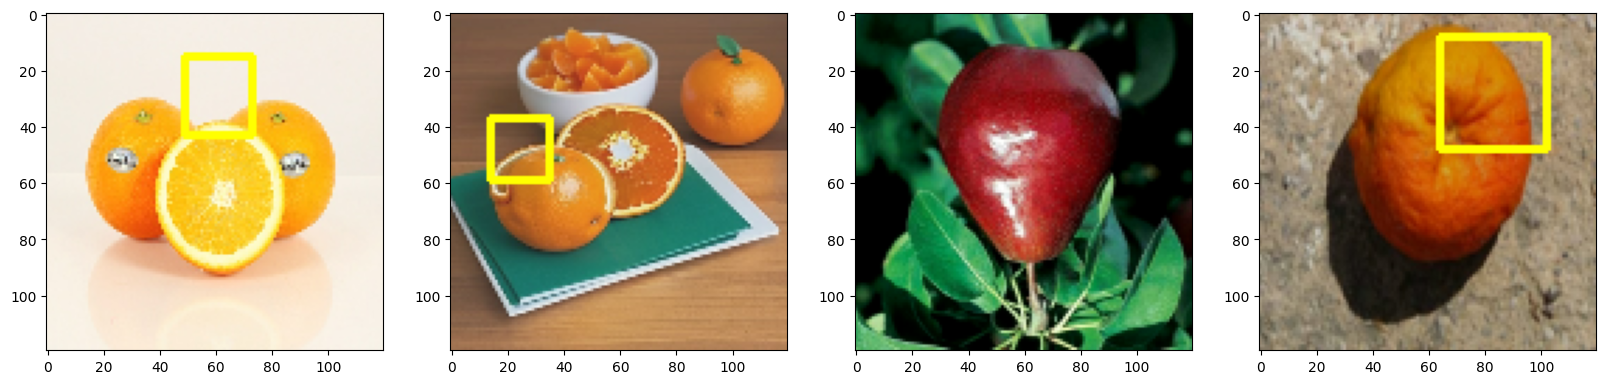

In [114]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx][0] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    elif yhat[0][idx][1] > 0.9:
            cv2.rectangle(sample_image, 
                tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (0,255,0), 2)

    elif yhat[0][idx][2] > 0.9:
         cv2.rectangle(sample_image, 
                tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,170,0), 2)
    
    ax[idx].imshow(sample_image)